#Deep Convolutional GANs
In this notebook, i'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here.](https://arxiv.org/pdf/1511.06434.pdf)
I'll train DCGAN on MNIST dataset. These are grayscale images of handwritten digits.

## Prepare some necessary libraries and packages


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary


## Constants for MNIST

In [3]:
width = 28
height = 28
channels = 1
epochs = 50

img_shape = (channels, width, height)

## Prepare dataset

In [4]:
# number of subprocesses to use for data loading
num_workers = 2

# convert data to torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# how many samples per batch to load
batch_size = 64

# get the training datasets
train_data = torchvision.datasets.MNIST(root= 'data', train=True,
                            download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True, num_workers=num_workers)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Visualize the data

 0  1  2  3  4  5  7  2  0  0  8  1  7  7  0  0  7  5  5  0  4  8  5  1  6  2  0  3  8  7  4  8  7  4  2  3  5  0  5  4  2  4  8  9  0  1  1  9  5  7  3  4  4  8  1  1  5  6  2  0  0  6  9  4


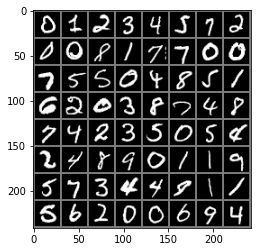

In [ ]:
def imshow(img):
    img = img / 2 + 0.5             # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))
#print label
print(' '.join('%2s' %labels[j].item() for j in range(batch_size)))

#Define the model

## Generator
The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a Grayscale image with the same size as the training images (i.e. 1x28x28). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [-1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. 

In [6]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = nn.Sequential(
            nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True)
        )
        self.t_conv2 = nn.Sequential(
            nn.ConvTranspose2d(conv_dim * 2, conv_dim , kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True)
        )
        self.t_conv3 = nn.Sequential(
            nn.ConvTranspose2d(conv_dim, 1 , kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        out = self.t_conv1(out)
        out = self.t_conv2(out)
        out = self.t_conv3(out)
        return out

## Discriminator
The discriminator, D, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 1x28x28 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.

In [7]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # transpose conv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv_dim, conv_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(conv_dim * 2, conv_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = output.view(-1, self.conv_dim*4*4*4)
        output = self.fc(output)
        return output

In [8]:
conv_dim = 32
z_size = 100

G = Generator(z_size=z_size, conv_dim=conv_dim)
D = Discriminator(conv_dim=conv_dim)
print(G)
print(D)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): 

In [9]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


## Losses

In [10]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizer

In [11]:
# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [12]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

G.train()
D.train()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = real_images * 2 - 1
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.5036 | g_loss: 0.7560
Epoch [    1/   50] | d_loss: 0.1938 | g_loss: 2.7412
Epoch [    1/   50] | d_loss: 0.1855 | g_loss: 3.9206
Epoch [    1/   50] | d_loss: 0.1634 | g_loss: 2.9881
Epoch [    2/   50] | d_loss: 0.1425 | g_loss: 3.2603
Epoch [    2/   50] | d_loss: 1.1907 | g_loss: 5.5286
Epoch [    2/   50] | d_loss: 0.2095 | g_loss: 3.2754
Epoch [    2/   50] | d_loss: 0.6124 | g_loss: 4.7907
Epoch [    3/   50] | d_loss: 1.6247 | g_loss: 7.0888
Epoch [    3/   50] | d_loss: 0.1278 | g_loss: 3.5890
Epoch [    3/   50] | d_loss: 0.2275 | g_loss: 3.1925
Epoch [    3/   50] | d_loss: 0.2958 | g_loss: 3.7803
Epoch [    4/   50] | d_loss: 0.1525 | g_loss: 3.9421
Epoch [    4/   50] | d_loss: 0.1409 | g_loss: 4.2751
Epoch [    4/   50] | d_loss: 0.1326 | g_loss: 2.2890
Epoch [    4/   50] | d_loss: 0.2508 | g_loss: 3.1403
Epoch [    5/   50] | d_loss: 0.3137 | g_loss: 2.6748
Epoch [    5/   50] | d_loss: 0.2194 | g_loss: 3.1800
Epoch [    5/   50] | d_loss

# Visualize the Training Loss

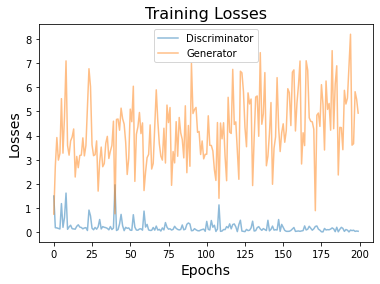

In [14]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.title("Training Losses", fontsize=16)
plt.legend()

#Generate fake images from Generator after training

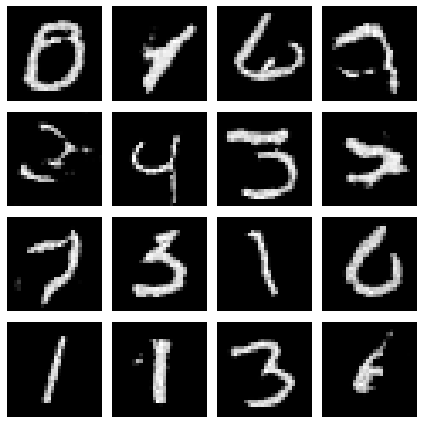

In [18]:
z = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
fake_images = G(z)
images = fake_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()